In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web
import quandl
quandl.ApiConfig.api_key = "KuL7iL8zUg7h8iZzXh9_"

#def gen_stock_info(ticker, start, end):
def gen_stock_info():
    #stock_df = quandl.get(''.join(['WIKI/', ticker]), start_date=start, end_date=end)
    stock_df=quandl.get("BCHARTS/BITSTAMPUSD")
    stock_df = stock_df[(stock_df['Open'] != 0) & (stock_df['Close'] != 0)]
    return stock_df  #only need some columns


def add_Moving_Ave(stock_df):
    ma_list = ['ma5','ma20', 'ma60', 'ma120']
    window_list = [5, 20, 60, 120]
    for ma, window_ in zip(ma_list, window_list):
        stock_df[ma] = stock_df['Close'].rolling(window=window_).mean()
    return stock_df
    
    
def add_STD(stock_df):
    std_list = ['std_20']
    window_list = [20]
    for std, window_ in zip(std_list, window_list):
        stock_df[std] = stock_df['Close'].rolling(window=window_).std()
    return stock_df


def draw_stock(stock_df, window_=365):

    plt.figure(figsize=(10,6))
    plt.plot(stock_df.index[-window_:],stock_df.Close[-window_:],label='Close')
    plt.plot(stock_df.index[-window_:],stock_df.ma5[-window_:],label='ma5')
    plt.plot(stock_df.index[-window_:],stock_df.ma20[-window_:],label='ma20')
    #plt.plot(stock_df.index[-window_:],stock_df.ma60[-window_:],label='ma60')
    #plt.plot(stock_df.index[-window_:],stock_df.ma120[-window_:],label='ma120')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

#functions for analysis of an algorithm after simulations    
#############################   
def gen_drawdown_record(list_, K): # including up to K-th largest one
    
    record_ =[] 
    for i in range(1, len(list_)-1):
        if list_[i] > list_[i+1] and list_[i] > list_[i-1]: #find some number that are greater than the numbers next to it
            
            num_of_found = 0
            j = i+1
            while (num_of_found == 0) & (j < len(list_)):  #I can only look at the values from current point to the end
                if list_[i] <= list_[j]: #This is when I find the value recovered
                    num_of_found += 1
                    k_index, min_ = 0, 9999999999
                    
                    if num_of_found == 1: # just make sure if the value is the first recovery found
                        for k in range(i+1, j): #Then between the start and the recovery, there should be a minimum 
                            if list_[k] < list_[k+1] and list_[k] < list_[k-1]:
                                if (min_ > list_[k]):
                                    k_index, min_ = k, list_[k] #This is the minimum I find during the drawdown
               
                        record_.append((list_[i]-min_, i, j)) 
                j = j+1
    
    if K > len(record_):
        return "K is greater than the number of drawdowns"
    else:        
        return sorted(record_, key= lambda pair:pair[0], reverse = True)[:K]
    
    
def draw_result_of_sim(stock_df):
    plt.figure(figsize=(10,6))
    plt.plot(stock_df['Close'], label='Close')
    plt.plot(stock_df['Cum_profit'],label='Cumulative_profit')
    plt.plot(stock_df['Net_profit'],label='Net_profit')
    plt.title('Bollinger Band strategy with targeted portion')
    plt.xlabel('Time')
    plt.ylabel('In Dollars')
    plt.legend(loc='best')
    plt.show()
    
def draw_return_dist(stock_df):
    dailyreturn = np.log(stock_df.Close)-np.log(stock_df.Close.shift(1))
    day_ret = np.array(dailyreturn[1:])
    import seaborn as sns
    from scipy import stats
    sns.distplot(day_ret, kde=True, rug=True, fit=stats.norm)    

def calc_quality_of_port(stock_df):
    return (stock_df.Cum_profit).mean()/(stock_df.Cum_profit).std()

def calc_max_drawdown(stock_df):
    max_drawdown, start_point = gen_drawdown_record(stock_df.Total_asset, 1)[0][:2]
    return -max_drawdown/(stock_df.Total_asset[start_point])*100

def get_final_total_value(stock_df):
    return stock_df.Cum_profit[-1]

#generate the stock info
stock_df = gen_stock_info()
stock_df = add_Moving_Ave(stock_df)
stock_df = add_STD(stock_df)
stock_df = stock_df.iloc[:,[0, 3, 7, 8, -1]]
stock_df = stock_df.iloc[19:,:]
ref_stock_df = stock_df.copy()

In [117]:
stock_df

,Open,Close,ma5,ma20,std_20
Date,,,,,
2011-10-05,4.92,4.92,4.882,5.2395,0.444563
2011-10-06,4.88,4.80,4.878,5.1810,0.419660
2011-10-07,4.80,4.61,4.836,5.1350,0.429694
2011-10-08,4.57,3.99,4.660,5.0780,0.500217
2011-10-09,3.89,3.89,4.442,5.0300,0.565099
2011-10-10,3.99,4.51,4.360,5.0120,0.576090
2011-10-11,3.98,4.10,4.220,4.9710,0.611098
2011-10-12,3.95,3.93,4.084,4.9225,0.654015
2011-10-13,3.93,3.97,4.080,4.8380,0.662830


In [2]:
def simulate_algo(ref_stock_df, init_cash = 1000, target_port_ratio=0.5):
    # init_cash = 1000 
    # target_port_ratio = 0.5
    stock_df = ref_stock_df.copy()
    stock_df.loc[:,'Cash']=0  
    stock_df.at[stock_df.index[0],'Cash']=init_cash
    stock_df.loc[:,'Inventory']=0
    stock_df.loc[:,'Port_val']=0
    stock_df.loc[:,'Total_asset']=0
    stock_df.at[stock_df.index[0],'Total_asset'] = stock_df.iloc[0]['Cash']+stock_df.iloc[0]['Port_val']
    stock_df.loc[:,'Net_profit']=0
    stock_df.loc[:,'Signal'] = 0



    def short(quantity, list_):
        open_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t - quantity 
        Cash_t = Cash_t + quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def long(quantity, list_):
        open_t, close_t, Cash_t, Inventory_t = list_

        Inventory_t = Inventory_t + quantity 
        Cash_t = Cash_t - quantity * open_t
        Port_val_t = Inventory_t * close_t
        Total_asset_t = Cash_t + Port_val_t 
        Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t


    def clear_position(quantity, list_):
        open_t, close_t, Cash_y, Inventory_y = list_

        if Inventory_y < 0: #clear some short positions
            Inventory_t = Inventory_y + quantity 
            Cash_t = Cash_y - quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        elif Inventory_y > 0: #clear some long positions
            Inventory_t = Inventory_y - quantity 
            Cash_t = Cash_y + quantity * open_t
            Port_val_t = Inventory_t * close_t
            Total_asset_t = Cash_t + Port_val_t 
            Net_profit_t = Total_asset_t - Total_asset_y

        return Cash_t, Inventory_t, Port_val_t, Total_asset_t, Net_profit_t  



    for i in range(1,len(stock_df)): 
        known_yesterday = stock_df.iloc[i-1,:] # all info
        known_today = stock_df.iloc[i,0] #only open price at the start of the market
        unknown_today = stock_df.iloc[i,1]
        open_y, close_y, ma5_y, ma20_y, std20_y, Cash_y, Inventory_y, Port_val_y, Total_asset_y, Net_profit_y, Signal_y = known_yesterday
        open_t = known_today
        close_t = unknown_today
        ref_list = (open_t, close_t, Cash_y, Inventory_y)
        targeted_quantity = Total_asset_y * target_port_ratio/open_t

        if Inventory_y == 0:
            if close_y >= ma20_y + std20_y:
                stock_df.loc[stock_df.index[i],'Signal'] = 1
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = long(targeted_quantity, ref_list)

            elif close_y <= ma20_y - std20_y:
                stock_df.loc[stock_df.index[i],'Signal'] = -1
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = short(targeted_quantity, ref_list)
            else:
                stock_df.iloc[i,[5, 6, 7, 8]] = stock_df.iloc[i-1,[5, 6, 7, 8]]
                stock_df.iloc[i,9] = 0 

        elif Inventory_y > 0:
            if close_y < ma5_y:
                stock_df.loc[stock_df.index[i],'Signal'] = 2  #clear the long positions
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = clear_position(abs(Inventory_y), ref_list)

            elif Inventory_y >= targeted_quantity:
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = clear_position(Inventory_y-targeted_quantity, ref_list)

            elif Inventory_y < targeted_quantity:    
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = long(targeted_quantity - abs(Inventory_y), ref_list)

        elif Inventory_y < 0:
            if close_y > ma5_y:
                stock_df.loc[stock_df.index[i],'Signal'] = -2  #clear the short positions
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = clear_position(abs(Inventory_y), ref_list)

            elif abs(Inventory_y) >= targeted_quantity:
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = clear_position(abs(Inventory_y)-targeted_quantity, ref_list)

            elif abs(Inventory_y) < targeted_quantity: 
                stock_df.iloc[i,[5, 6, 7, 8, 9]] = short(targeted_quantity - abs(Inventory_y), ref_list)
                
    stock_df['Cum_profit']=stock_df['Net_profit'].cumsum()
    return stock_df


In [119]:
simulate_algo(stock_df)

,Open,Close,ma5,ma20,std_20,Cash,Inventory,Port_val,Total_asset,Net_profit,Signal,Cum_profit
Date,,,,,,,,,,,,
2011-10-05,4.92,4.92,4.882,5.2395,0.444563,1000.000000,0.000000,0.000000,1000.000000,0.000000,0,0.000000
2011-10-06,4.88,4.80,4.878,5.1810,0.419660,1000.000000,0.000000,0.000000,1000.000000,0.000000,0,0.000000
2011-10-07,4.80,4.61,4.836,5.1350,0.429694,1000.000000,0.000000,0.000000,1000.000000,0.000000,0,0.000000
2011-10-08,4.57,3.99,4.660,5.0780,0.500217,1500.000000,-109.409190,-436.542670,1063.457330,63.457330,-1,63.457330
2011-10-09,3.89,3.89,4.442,5.0300,0.565099,1606.126915,-136.691174,-531.728665,1074.398249,10.940919,0,74.398249
2011-10-10,3.99,4.51,4.360,5.0120,0.576090,1597.928257,-134.636372,-607.210038,990.718219,-83.680031,0,-9.281781
2011-10-11,3.98,4.10,4.220,4.9710,0.611098,1062.075496,0.000000,0.000000,1062.075496,71.357277,-2,62.075496
2011-10-12,3.95,3.93,4.084,4.9225,0.654015,1593.113244,-134.439936,-528.348949,1064.764295,2.688799,-1,64.764295
2011-10-13,3.93,3.97,4.080,4.8380,0.662830,1597.146442,-135.466195,-537.800795,1059.345647,-5.418648,0,59.345647


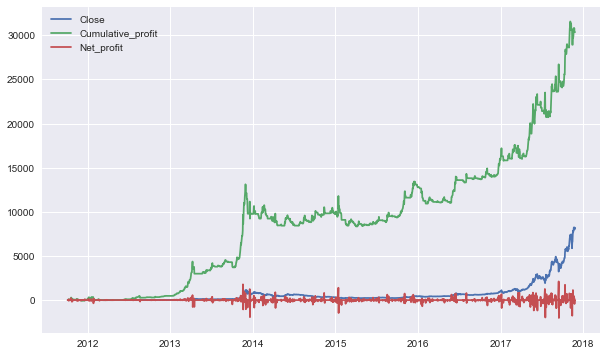

In [120]:
draw_result_of_sim(simulate_algo(stock_df))

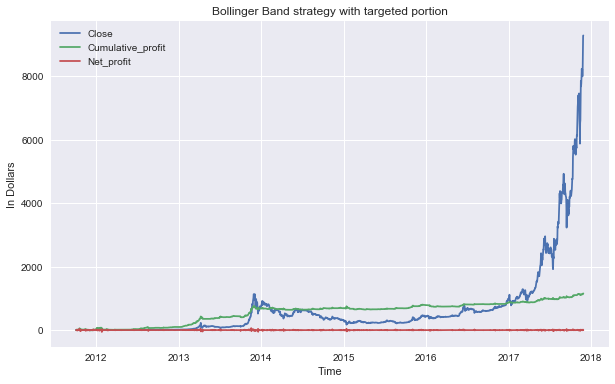

     Targeted portion = 0.1
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 1153.06
     The Quality of the Portfolio is 1.77
     Max Drawdown is -6.93 %


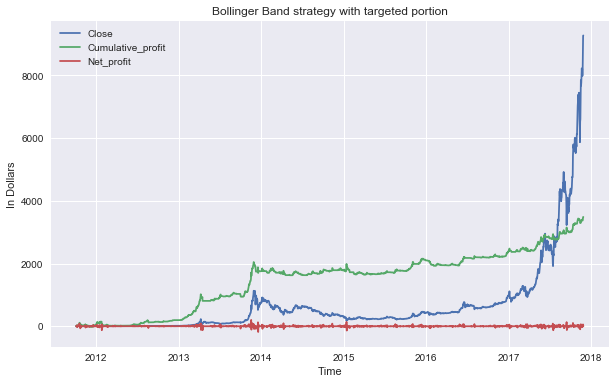

     Targeted portion = 0.2
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 3485.53
     The Quality of the Portfolio is 1.64
     Max Drawdown is -13.73 %


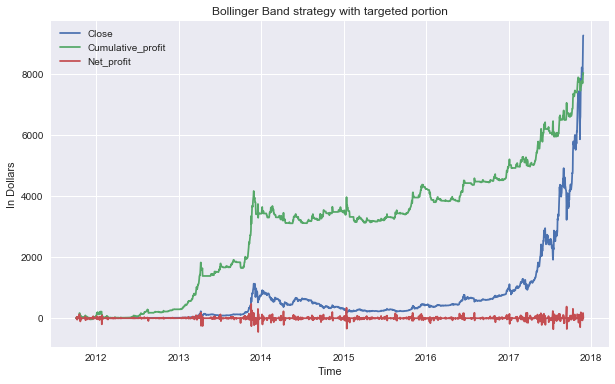

     Targeted portion = 0.3
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 8044.86
     The Quality of the Portfolio is 1.52
     Max Drawdown is -20.42 %


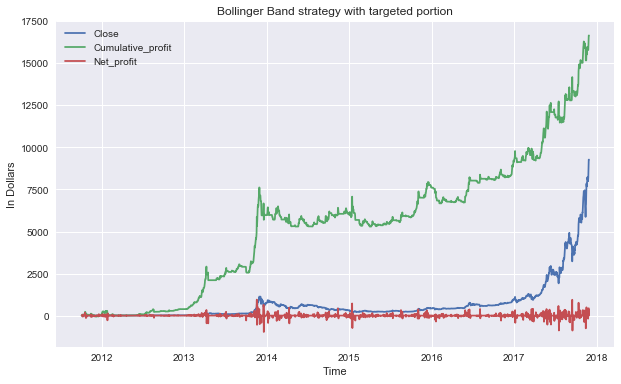

     Targeted portion = 0.4
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 16656.91
     The Quality of the Portfolio is 1.4
     Max Drawdown is -27.01 %


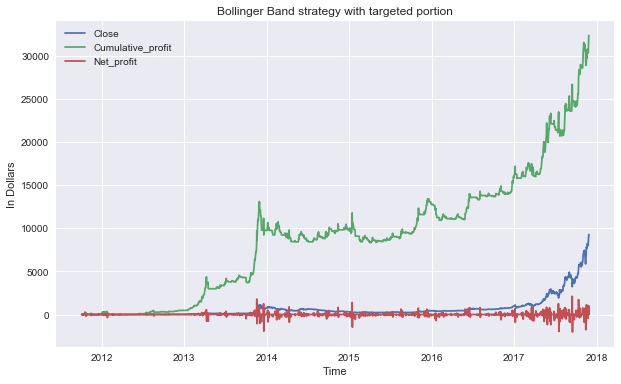

     Targeted portion = 0.5
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 32374.29
     The Quality of the Portfolio is 1.29
     Max Drawdown is -33.81 %


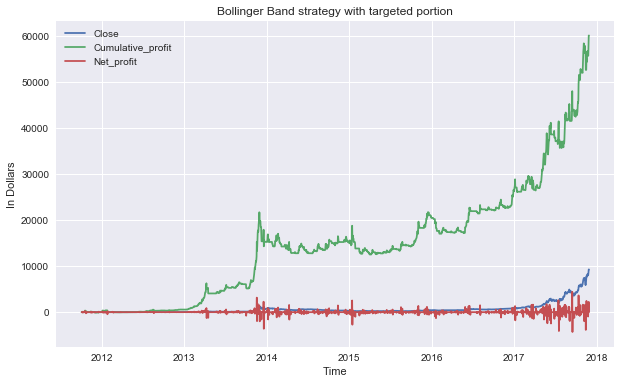

     Targeted portion = 0.6
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 60083.26
     The Quality of the Portfolio is 1.18
     Max Drawdown is -40.44 %


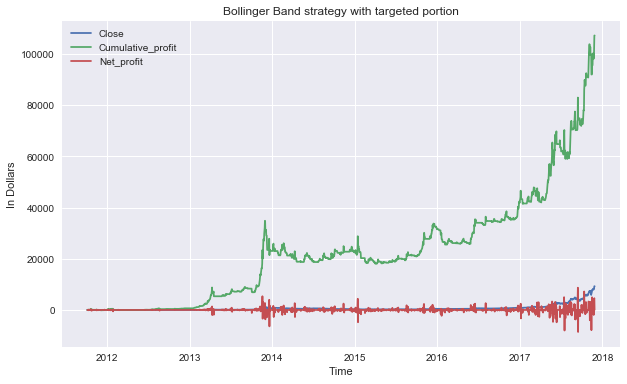

     Targeted portion = 0.7
     Initial Investment Value $ 1000.00
     Final Portfolio Value: $ 107252.96
     The Quality of the Portfolio is 1.09
     Max Drawdown is -46.84 %


In [3]:
test_portion_list = np.arange(0.1, 0.8, 0.1) 
result_list = []
for portion in test_portion_list:
    temp_result_df = simulate_algo(stock_df, init_cash=1000, target_port_ratio=portion)
    result_list.append([get_final_total_value(temp_result_df), calc_quality_of_port(temp_result_df), calc_max_drawdown(temp_result_df)]) 
    draw_result_of_sim(temp_result_df)
    print('     Targeted portion =', portion)
    print('     Initial Investment Value $ 1000.00')
    print('     Final Portfolio Value: $', round(result_list[-1][0],2))
    print('     The Quality of the Portfolio is', round(result_list[-1][1],2))
    print('     Max Drawdown is', round(result_list[-1][2], 2), '%')

In [122]:
stock_df = simulate_algo(stock_df)
print('Initial Investment Value $ 1000.00')
print('Final Portfolio Value: $', get_final_total_value(stock_df))
print('The Quality of the Portfolio is', calc_quality_of_port(stock_df))
print('Max Drawdown is', calc_max_drawdown(stock_df), '%')

Initial Investment Value $ 1000.00
Final Portfolio Value: $ 30338.1686781
The Quality of the Portfolio is 1.2896339218567248
Max Drawdown is -33.8077477749 %


In [124]:
stock_df = simulate_algo(ref_stock_df=ref_stock_df, init_cash=1000, target_port_ratio=0.4)
print('Initial Investment Value $ 1000.00')
print('Final Portfolio Value: $', get_final_total_value(stock_df))
print('The Quality of the Portfolio is', calc_quality_of_port(stock_df))
print('Max Drawdown is', calc_max_drawdown(stock_df), '%')

Initial Investment Value $ 1000.00
Final Portfolio Value: $ 15787.107424
The Quality of the Portfolio is 1.4001356986639144
Max Drawdown is -27.0095923051 %
